 # Plots for linear network with 1 hidden layer

In [1]:
import os
import pydove as dv

import numpy as np
import torch
import optuna
import pickle

from tqdm.notebook import tqdm
from functools import partial

from cpcn import LinearBioPCN, PCNetwork, load_mnist, Trainer

 ## Setup

In [2]:
seed = 32890
n_epochs = 15
n_reps = 8
dims = [784, 5, 10]

device = torch.device("cpu")

# for reproducibility
torch.manual_seed(seed)

# this creates the loaders, by default
dataset = load_mnist(n_validation=10000, device=device)

 ## Load optimal parameters

In [3]:
with open(os.path.join("save", "hyperopt_pcn.pkl"), "rb") as f:
    study_pcn = pickle.load(f)
    best_pcn = study_pcn.best_params
with open(os.path.join("save", "hyperopt_biopcn.pkl"), "rb") as f:
    study_cpcn = pickle.load(f)
    best_cpcn = study_cpcn.best_params

 ## Train

In [4]:
pcn_results = []
cpcn_results = []

# parameters to be used for CPCN
g_a = 0.5 * np.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * np.ones(len(dims) - 2)
g_b[0] *= 2

rho = 0.015
z_it = 80

for i in tqdm(range(n_reps), desc="repetitions"):
    # train PCN
    torch.manual_seed(seed + i)

    pcn = PCNetwork(
        dims,
        activation=lambda _: _,
        lr_inference=best_pcn["z_lr"],
        it_inference=z_it,
        variances=1.0,
        constrained=True,
        rho=rho,
        bias=False,
    ).to(device)

    pcn_trainer = Trainer(pcn, dataset["train"], dataset["validation"])
    pcn_trainer.set_classifier("linear")

    pcn_trainer.set_optimizer(torch.optim.Adam, lr=best_pcn["lr"])
    # trainer.add_scheduler(partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.99))

    pcn_out = pcn_trainer.run(n_epochs, progress=partial(tqdm, desc="PCN"))

    # train CPCN
    torch.manual_seed(seed + i)

    cpcn = LinearBioPCN(
        dims,
        z_lr=best_cpcn["z_lr"],
        z_it=z_it,
        g_a=g_a,
        g_b=g_b,
        c_m=0,
        l_s=g_b,
        rho=rho,
        bias_a=False,
        bias_b=False,
    ).to(device)

    cpcn_trainer = Trainer(cpcn, dataset["train"], dataset["validation"])
    cpcn_trainer.set_classifier("linear")

    cpcn_trainer.set_optimizer(torch.optim.Adam, lr=best_cpcn["lr"])
    # cpcn_trainer.add_scheduler(partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.997))

    cpcn_out = cpcn_trainer.run(n_epochs, progress=partial(tqdm, desc="BioPCN"))

    # store the results
    pcn_results.append({"trainer": pcn_trainer, "output": pcn_out, "net": pcn})
    cpcn_results.append({"trainer": cpcn_trainer, "output": cpcn_out, "net": cpcn})

with open("linear_1hidden_results.pkl", "wb") as f:
    pickle.dump(
        {
            "pcn_params": best_pcn,
            "cpcn_params": best_cpcn,
            "pcn": [_["output"] for _ in pcn_results],
            "cpcn": [_["output"] for _ in cpcn_results],
        },
        f,
    )

repetitions:   0%|          | 0/8 [00:00<?, ?it/s]

PCN:   0%|          | 0/15 [00:00<?, ?it/s]

BioPCN:   0%|          | 0/15 [00:00<?, ?it/s]

PCN:   0%|          | 0/15 [00:00<?, ?it/s]

BioPCN:   0%|          | 0/15 [00:00<?, ?it/s]

PCN:   0%|          | 0/15 [00:00<?, ?it/s]

BioPCN:   0%|          | 0/15 [00:00<?, ?it/s]

PCN:   0%|          | 0/15 [00:00<?, ?it/s]

BioPCN:   0%|          | 0/15 [00:00<?, ?it/s]

PCN:   0%|          | 0/15 [00:00<?, ?it/s]

BioPCN:   0%|          | 0/15 [00:00<?, ?it/s]

PCN:   0%|          | 0/15 [00:00<?, ?it/s]

BioPCN:   0%|          | 0/15 [00:00<?, ?it/s]

PCN:   0%|          | 0/15 [00:00<?, ?it/s]

BioPCN:   0%|          | 0/15 [00:00<?, ?it/s]

PCN:   0%|          | 0/15 [00:00<?, ?it/s]

BioPCN:   0%|          | 0/15 [00:00<?, ?it/s]

 ## Plot results

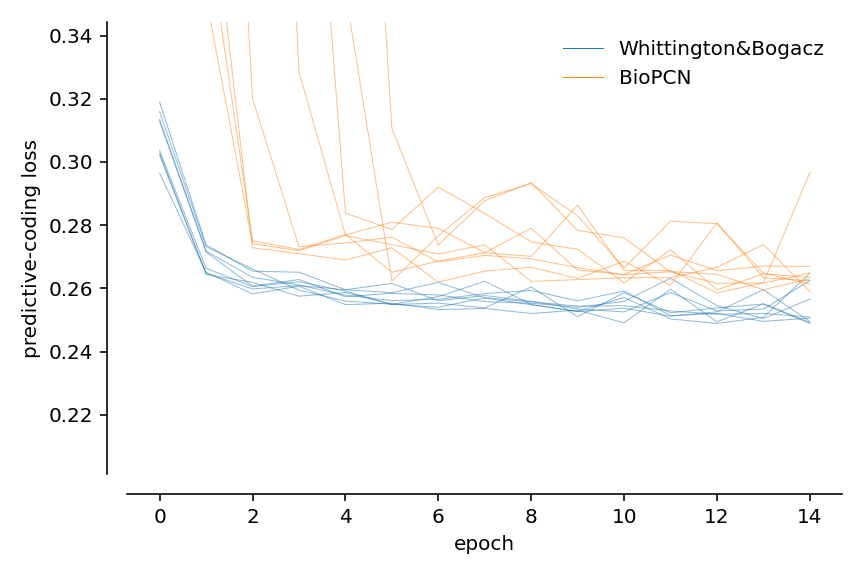

In [12]:
with dv.FigureManager() as (_, ax):
    last_val_max = 0
    last_val_min = np.inf
    for crt_pcn in pcn_results:
        ax.plot(crt_pcn["output"].validation["pc_loss"], c="C0", alpha=0.5, lw=0.5)
        last_val_max = max(last_val_max, crt_pcn["output"].validation["pc_loss"][-1])
        last_val_min = min(last_val_min, crt_pcn["output"].validation["pc_loss"][-1])

    for crt_cpcn in cpcn_results:
        ax.plot(crt_cpcn["output"].validation["pc_loss"], c="C1", alpha=0.5, lw=0.5)
        last_val_max = max(last_val_max, crt_cpcn["output"].validation["pc_loss"][-1])
        last_val_min = min(last_val_min, crt_cpcn["output"].validation["pc_loss"][-1])

    ax.plot([], c="C0", lw=0.5, label="Whittington&Bogacz")
    ax.plot([], c="C1", lw=0.5, label="BioPCN")

    ax.legend(frameon=False)
    ax.set_xlabel("epoch")
    ax.set_ylabel("predictive-coding loss")

    last_val_center = 0.5 * (last_val_min + last_val_max)
    last_val_range = 0.5 * (last_val_max - last_val_min)
    ax.set_ylim(
        last_val_center - 3 * last_val_range, last_val_center + 3 * last_val_range
    )

    # ax.set_ylim(None, 0.4)

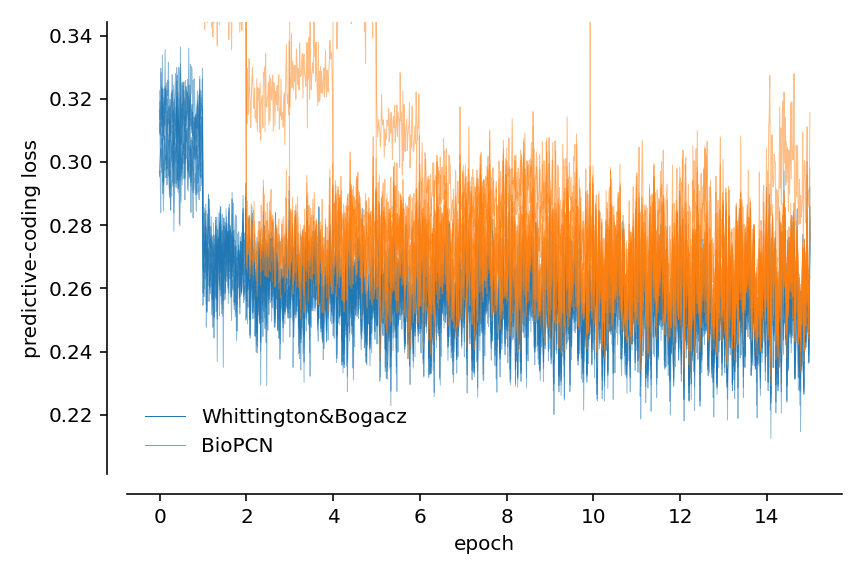

In [13]:
with dv.FigureManager() as (_, ax):
    for crt_pcn in pcn_results:
        n_batch = crt_pcn["output"].batch_validation["batch"].max() + 1
        idx = (
            crt_pcn["output"].batch_validation["epoch"]
            + crt_pcn["output"].batch_validation["batch"] / n_batch
        )
        ax.plot(
            idx,
            crt_pcn["output"].batch_validation["pc_loss"],
            c="C0",
            alpha=0.5,
            lw=0.5,
        )

    for crt_cpcn in cpcn_results:
        n_batch = crt_cpcn["output"].batch_validation["batch"].max() + 1
        idx = (
            crt_cpcn["output"].batch_validation["epoch"]
            + crt_cpcn["output"].batch_validation["batch"] / n_batch
        )
        ax.plot(
            idx,
            crt_cpcn["output"].batch_validation["pc_loss"],
            c="C1",
            alpha=0.5,
            lw=0.5,
        )

    ax.plot([], c="C0", lw=0.5, label="Whittington&Bogacz")
    ax.plot([], c="C1", lw=0.5, label="BioPCN")
    ax.legend(frameon=False)

    ax.set_xlabel("epoch")
    ax.set_ylabel("predictive-coding loss")

    ax.set_ylim(
        last_val_center - 3 * last_val_range, last_val_center + 3 * last_val_range
    )

    # ax.set_ylim(None, 0.4)